L'objectif de ce NB est de vérifier la distribution de la solution du problème de moindres carrés linéaires. Plus précisément, on vérifie que la covariance de la loi gaussienne associée à la méthode `getParameterPosterior` est correcte pour la classe `LinearLeastSquaresCalibration`. 
Une difficulté pour valider le résultat est que le modèle de Chaboche n'est que approximativement linéaire.

## Generate the observations

In [1]:
"""
A graphics class to analyze the results of calibration.
"""

import pylab as pl
import openturns as ot
import openturns.viewer as otv

class CalibrationAnalysis:
    def __init__(self,calibrationResult,model,inputObservations,outputObservations):
        """
        Plots the prior and posterior distribution of the calibrated parameter theta.
    
        Parameters
        ----------
        calibrationResult : :class:`~openturns.calibrationResult`
            The result of a calibration.
    
        model : 2-d sequence of float
            The function to calibrate.
    
        inputObservations : :class:`~openturns.Sample`
            The sample of input values of the model linked to the observations.
    
        outputObservations : 2-d sequence of float
            The sample of output values of the model linked to the observations.
        """
        self.model = model
        self.outputAtPrior = None
        self.outputAtPosterior = None
        self.calibrationResult = calibrationResult
        self.observationColor = "blue"
        self.priorColor = "red"
        self.posteriorColor = "green"
        self.inputObservations = inputObservations
        self.outputObservations = outputObservations
        self.unitlength = 6 # inch
        # Compute yAtPrior
        meanPrior = calibrationResult.getParameterPrior().getMean()
        model.setParameter(meanPrior)
        self.outputAtPrior=model(inputObservations)
        # Compute yAtPosterior
        meanPosterior = calibrationResult.getParameterPosterior().getMean()
        model.setParameter(meanPosterior)
        self.outputAtPosterior=model(inputObservations)
        return None

    def drawParameterDistributions(self):
        """
        Plots the prior and posterior distribution of the calibrated parameter theta.
        """
        thetaPrior = self.calibrationResult.getParameterPrior()
        thetaDescription = thetaPrior.getDescription()
        thetaPosterior = self.calibrationResult.getParameterPosterior()
        thetaDim = thetaPosterior.getDimension()
        fig = pl.figure(figsize=(12, 4))
        for i in range(thetaDim):
            graph = ot.Graph("",thetaDescription[i],"PDF",True,"topright")
            # Prior distribution
            thetaPrior_i = thetaPrior.getMarginal(i)
            priorPDF = thetaPrior_i.drawPDF()
            priorPDF.setColors([self.priorColor])
            priorPDF.setLegends(["Prior"])
            graph.add(priorPDF)
            # Posterior distribution
            thetaPosterior_i = thetaPosterior.getMarginal(i)
            postPDF = thetaPosterior_i.drawPDF()
            postPDF.setColors([self.posteriorColor])
            postPDF.setLegends(["Posterior"])
            graph.add(postPDF)
            '''
            If the prior is a Dirac, set the vertical axis bounds to the posterior. 
            Otherwise, the Dirac set to [0,1], where the 1 can be much larger 
            than the maximum PDF of the posterior.
            '''
            if (thetaPrior_i.getName()=="Dirac"):
                # The vertical (PDF) bounds of the posterior
                postbb = postPDF.getBoundingBox()
                pdf_upper = postbb.getUpperBound()[1]
                pdf_lower = postbb.getLowerBound()[1]
                # Set these bounds to the graph
                bb = graph.getBoundingBox()
                graph_upper = bb.getUpperBound()
                graph_upper[1] = pdf_upper
                bb.setUpperBound(graph_upper)
                graph_lower = bb.getLowerBound()
                graph_lower[1] = pdf_lower
                bb.setLowerBound(graph_lower)
                graph.setBoundingBox(bb)
            # Add it to the graphics
            ax = fig.add_subplot(1, thetaDim, i+1)
            _ = otv.View(graph, figure=fig, axes=[ax])
        return fig
    
    def drawObservationsVsPredictions(self):
        """
        Plots the output of the model depending 
        on the output observations before and after calibration.
        """
        
        ySize = self.outputObservations.getSize()
        yDim = self.outputObservations.getDimension()
        graph = ot.Graph("","Observations","Predictions",True,"topleft")
        # Plot the diagonal
        if (yDim==1):
            graph = self._drawObservationsVsPredictions1Dimension(self.outputObservations,self.outputAtPrior,self.outputAtPosterior)
        elif (ySize==1):
            outputObservations = ot.Sample(self.outputObservations[0],1)
            outputAtPrior = ot.Sample(self.outputAtPrior[0],1)
            outputAtPosterior = ot.Sample(self.outputAtPosterior[0],1)
            graph = self._drawObservationsVsPredictions1Dimension(outputObservations,outputAtPrior,outputAtPosterior)
        else:
            fig = pl.figure(figsize=(self.unitlength*yDim, self.unitlength))
            for i in range(yDim):
                outputObservations = self.outputObservations[:,i]
                outputAtPrior = self.outputAtPrior[:,i]
                outputAtPosterior = self.outputAtPosterior[:,i]
                graph = self._drawObservationsVsPredictions1Dimension(outputObservations,outputAtPrior,outputAtPosterior)
                ax = fig.add_subplot(1, yDim, i+1)
                _ = otv.View(graph, figure=fig, axes=[ax])

        return graph

    def _drawObservationsVsPredictions1Dimension(self,outputObservations,outputAtPrior,outputAtPosterior):
        """
        Plots the output of the model depending 
        on the output observations before and after calibration.
        Can manage only 1D samples.
        """
        yDim = outputObservations.getDimension()
        ydescription = outputObservations.getDescription()
        xlabel = "%s Observations" % (ydescription[0])
        ylabel = "%s Predictions" % (ydescription[0])
        graph = ot.Graph("",xlabel,ylabel,True,"topleft")
        # Plot the diagonal
        if (yDim==1):
            curve = ot.Curve(outputObservations, outputObservations)
            curve.setColor(self.observationColor)
            graph.add(curve)
        else:
            raise TypeError('Output observations are not 1D.')
        # Plot the predictions before
        yPriorDim = outputAtPrior.getDimension()
        if (yPriorDim==1):
            cloud = ot.Cloud(outputObservations, outputAtPrior)
            cloud.setColor(self.priorColor)
            cloud.setLegend("Prior")
            graph.add(cloud)
        else:
            raise TypeError('Output prior predictions are not 1D.')
        # Plot the predictions after
        yPosteriorDim = outputAtPosterior.getDimension()
        if (yPosteriorDim==1):
            cloud = ot.Cloud(outputObservations, outputAtPosterior)
            cloud.setColor(self.posteriorColor)
            cloud.setLegend("Posterior")
            graph.add(cloud)
        else:
            raise TypeError('Output posterior predictions are not 1D.')
        return graph
    
    def drawResiduals(self):
        """
        Plot the distribution of the residuals and 
        the distribution of the observation errors. 
        """    
        ySize = self.outputObservations.getSize()
        yDim = self.outputObservations.getDimension()
        yPriorSize = self.outputAtPrior.getSize()
        yPriorDim = self.outputAtPrior.getDimension()
        if (yDim==1):
            observationsError = self.calibrationResult.getObservationsError()
            graph = self._drawResiduals1Dimension(self.outputObservations,self.outputAtPrior,self.outputAtPosterior,observationsError)
        elif (ySize==1):
            outputObservations = ot.Sample(self.outputObservations[0],1)
            outputAtPrior = ot.Sample(self.outputAtPrior[0],1)
            outputAtPosterior = ot.Sample(self.outputAtPosterior[0],1)
            observationsError = self.calibrationResult.getObservationsError()
            # In this case, we cannot draw observationsError ; just 
            # pass the required input argument, but it is not actually used.
            graph = self._drawResiduals1Dimension(outputObservations,outputAtPrior,outputAtPosterior,observationsError)
        else:
            observationsError = self.calibrationResult.getObservationsError()
            fig = pl.figure(figsize=(self.unitlength*yDim, self.unitlength))
            for i in range(yDim):
                outputObservations = self.outputObservations[:,i]
                outputAtPrior = self.outputAtPrior[:,i]
                outputAtPosterior = self.outputAtPosterior[:,i]
                observationsErrorYi = observationsError.getMarginal(i)
                graph = self._drawResiduals1Dimension(outputObservations,outputAtPrior,outputAtPosterior,observationsErrorYi)
                ax = fig.add_subplot(1, yDim, i+1)
                _ = otv.View(graph, figure=fig, axes=[ax])
        return graph

    def _drawResiduals1Dimension(self,outputObservations,outputAtPrior,outputAtPosterior,observationsError):
        """
        Plot the distribution of the residuals and 
        the distribution of the observation errors. 
        Can manage only 1D samples.
        """    
        ydescription = outputObservations.getDescription()
        xlabel = "%s Residuals" % (ydescription[0])
        graph = ot.Graph("Residuals analysis",xlabel,"Probability distribution function",True,"topright")
        yDim = outputObservations.getDimension()
        yPriorDim = outputAtPrior.getDimension()
        yPosteriorDim = outputAtPrior.getDimension()
        if (yDim==1) and (yPriorDim==1) :
            posteriorResiduals = outputObservations - outputAtPrior
            kernel = ot.KernelSmoothing()
            fittedDist = kernel.build(posteriorResiduals)
            residualPDF = fittedDist.drawPDF()
            residualPDF.setColors([self.priorColor])
            residualPDF.setLegends(["Prior"])
            graph.add(residualPDF)
        else:
            raise TypeError('Output prior observations are not 1D.')
        if (yDim==1) and (yPosteriorDim==1) :
            posteriorResiduals = outputObservations - outputAtPosterior
            kernel = ot.KernelSmoothing()
            fittedDist = kernel.build(posteriorResiduals)
            residualPDF = fittedDist.drawPDF()
            residualPDF.setColors([self.posteriorColor])
            residualPDF.setLegends(["Posterior"])
            graph.add(residualPDF)
        else:
            raise TypeError('Output posterior observations are not 1D.')
        # Plot the distribution of the observation errors
        if (observationsError.getDimension()==1):
            # In the other case, we just do not plot
            obserrgraph = observationsError.drawPDF()
            obserrgraph.setColors([self.observationColor])
            obserrgraph.setLegends(["Observation errors"])
            graph.add(obserrgraph)
        return graph

    def drawObservationsVsInputs(self):
        """
        Plots the observed output of the model depending 
        on the observed input before and after calibration.
        """
        xSize = self.inputObservations.getSize()
        ySize = self.outputObservations.getSize()
        xDim = self.inputObservations.getDimension()
        yDim = self.outputObservations.getDimension()
        xdescription = self.inputObservations.getDescription()
        ydescription = self.outputObservations.getDescription()
        # Observations
        if (xDim==1) and (yDim==1):
            graph = self._drawObservationsVsInputs1Dimension(self.inputObservations,self.outputObservations,self.outputAtPrior,self.outputAtPosterior)
        elif (xSize==1) and (ySize==1):
            inputObservations = ot.Sample(self.inputObservations[0],1)
            outputObservations = ot.Sample(self.outputObservations[0],1)
            outputAtPrior = ot.Sample(self.outputAtPrior[0],1)
            outputAtPosterior = ot.Sample(self.outputAtPosterior[0],1)
            graph = self._drawObservationsVsInputs1Dimension(inputObservations,outputObservations,outputAtPrior,outputAtPosterior)
        else:
            fig = pl.figure(figsize=(xDim*self.unitlength, yDim*self.unitlength))
            for i in range(xDim):
                for j in range(yDim):
                    k = xDim * j + i
                    inputObservations = self.inputObservations[:,i]
                    outputObservations = self.outputObservations[:,j]
                    outputAtPrior = self.outputAtPrior[:,j]
                    outputAtPosterior = self.outputAtPosterior[:,j]
                    graph = self._drawObservationsVsInputs1Dimension(inputObservations,outputObservations,outputAtPrior,outputAtPosterior)
                    ax = fig.add_subplot(yDim, xDim, k+1)
                    _ = otv.View(graph, figure=fig, axes=[ax])
        return graph

    def _drawObservationsVsInputs1Dimension(self,inputObservations,outputObservations,outputAtPrior,outputAtPosterior):
        """
        Plots the observed output of the model depending 
        on the observed input before and after calibration.
        Can manage only 1D samples.
        """
        xDim = inputObservations.getDimension()
        if (xDim!=1):
            raise TypeError('Input observations are not 1D.')
        yDim = outputObservations.getDimension()
        xdescription = inputObservations.getDescription()
        ydescription = outputObservations.getDescription()
        graph = ot.Graph("",xdescription[0],ydescription[0],True,"topright")
        # Observations
        if (yDim==1):
            cloud = ot.Cloud(inputObservations,outputObservations)
            cloud.setColor(self.observationColor)
            cloud.setLegend("Observations")
            graph.add(cloud)
        else:
            raise TypeError('Output observations are not 1D.')
        # Model outputs before calibration
        yPriorDim = outputAtPrior.getDimension()
        if (yPriorDim==1):
            cloud = ot.Cloud(inputObservations,outputAtPrior)
            cloud.setColor(self.priorColor)
            cloud.setLegend("Prior")
            graph.add(cloud)
        else:
            raise TypeError('Output prior predictions are not 1D.')
        # Model outputs after calibration
        yPosteriorDim = outputAtPosterior.getDimension()
        if (yPosteriorDim==1):
            cloud = ot.Cloud(inputObservations,outputAtPosterior)
            cloud.setColor(self.posteriorColor)
            cloud.setLegend("Posterior")
            graph.add(cloud)
        else:
            raise TypeError('Output posterior predictions are not 1D.')
        return graph

In [2]:
import numpy as np
import openturns as ot

In [3]:
ot.RandomGenerator.SetSeed(0)

In [4]:
def modelChaboche(X):
    strain,R,C,gamma = X
    stress = R + C*(1-np.exp(-gamma*strain))
    return [stress]

In [5]:
g = ot.PythonFunction(4, 1, modelChaboche) 

In [6]:
unknownR = 750
unknownC = 2750
unknownGamma = 10
unknownParameter = ot.Point([unknownR,unknownC,unknownGamma])
descr = ["R", "C", "Gamma"]
unknownParameter

class=Point name=Unnamed dimension=3 values=[750,2750,10]

In [7]:
calibratedIndices = [1,2,3]
model = ot.ParametricFunction(g, calibratedIndices, unknownParameter)

In [8]:
R = 700 # Exact : 750e6
C = 2500 # Exact : 2750e6
Gamma = 8. # Exact : 10
candidate = ot.Point([R,C,Gamma])
candidate

class=Point name=Unnamed dimension=3 values=[700,2500,8]

In [9]:
parameterDimension = candidate.getDimension()
parameterDimension

3

In [10]:
Strain = ot.Uniform(0,0.07)
R = ot.Dirac(unknownR)
C = ot.Dirac(unknownC)
Gamma = ot.Dirac(unknownGamma)

Strain.setDescription(["Strain"])
R.setDescription(["R"])
C.setDescription(["C"])
Gamma.setDescription(["Gamma"])
    
inputRandomVector = ot.ComposedDistribution([Strain, R, C, Gamma])

In [11]:
def generateTheta(size, observationOutputNoise, candidate):
    # 1. Generate exact outputs
    inputSample = inputRandomVector.getSample(size)
    outputStress = g(inputSample)
    # 2. Add noise
    sampleNoiseH = observationOutputNoise.getSample(size)
    outputObservations = outputStress + sampleNoiseH
    # 3. Calibrate
    inputObservations = inputSample[:,0]
    algo = ot.LinearLeastSquaresCalibration(model, inputObservations, outputObservations, candidate, "SVD")
    algo.run()
    calibrationResult = algo.getResult()
    return calibrationResult, inputObservations

## Calibration

In [12]:
stressObservationNoiseSigma = 40. # (Pa)
observationOutputNoise = ot.Normal(0.,stressObservationNoiseSigma)

In [43]:
size = 10
calibrationResult, inputObservations = generateTheta(size, observationOutputNoise, candidate)

In [44]:
outputObservations = calibrationResult.getOutputObservations()

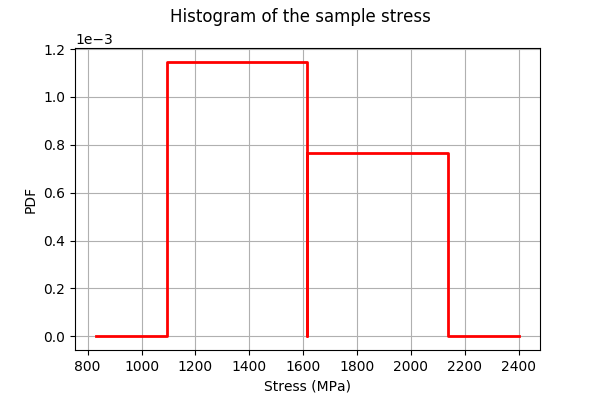

In [45]:
histoGraph = ot.HistogramFactory().build(outputObservations).drawPDF()
histoGraph.setTitle("Histogram of the sample stress")
histoGraph.setXTitle("Stress (MPa)")
histoGraph.setLegends([""])
histoGraph

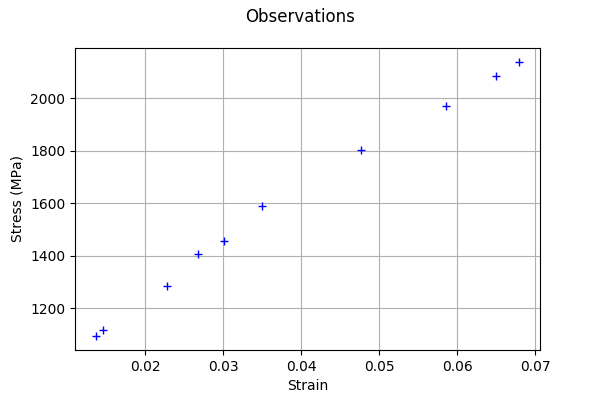

In [46]:
graph = ot.Graph("Observations","Strain","Stress (MPa)",True)
# Observations
cloud = ot.Cloud(inputObservations,outputObservations)
graph.add(cloud)
graph

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [47]:
thetaStar = calibrationResult.getParameterMAP()
thetaStar

class=Point name=Unnamed dimension=3 values=[729.315,2786.9,10.3425]

In [48]:
thetaPosterior = calibrationResult.getParameterPosterior()
thetaPosterior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[729.315,2786.9,10.3425] sigma=class=Point name=Unnamed dimension=3 values=[1256.39,22193.5,103.025] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.879269,-0.913315,0.879269,1,-0.996562,-0.913315,-0.996562,1]

In [49]:
covarianceThetaStarOT = thetaPosterior.getCovariance()
covarianceThetaStarOT

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1.57853e+06,2.45174e+07,-118220,2.45174e+07,4.92553e+08,-2.27864e+06,-118220,-2.27864e+06,10614.2]

## Draw residual distribution

The goal is to check the distribution of the residuals.

In [50]:
residualDistribution = calibrationResult.getObservationsError()
residualDistribution

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[649.14] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

In [51]:
# Compute yAtPosterior
meanPosterior = calibrationResult.getParameterPosterior().getMean()
model.setParameter(meanPosterior)
outputAtPosterior=model(inputObservations)

In [52]:
outputObservations = calibrationResult.getOutputObservations()

In [53]:
posteriorResiduals = outputAtPosterior - outputObservations

In [54]:
kernel = ot.KernelSmoothing()
fittedDist = kernel.build(posteriorResiduals)
residualPDF = fittedDist.drawPDF()
residualPDF.setColors(["green"])

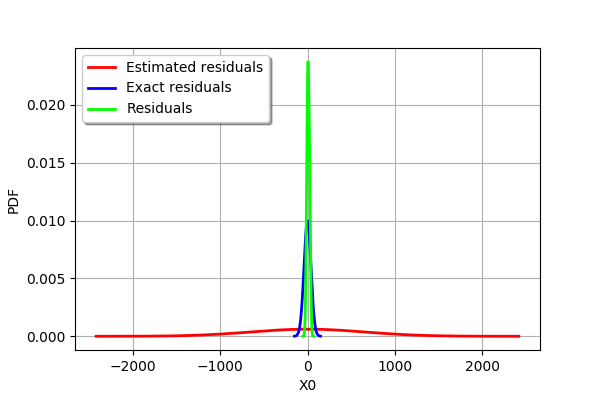

In [55]:
graph = residualDistribution.drawPDF()
graphExact = observationOutputNoise.drawPDF()
graphExact.setColors(["blue"])
graph.add(graphExact)
graph.add(residualPDF)
graph.setLegends(["Estimated residuals","Exact residuals","Residuals"])
graph.setLegendPosition("topleft")
graph

In [57]:
model.setParameter(unknownParameter)
for i in range(size):
    print(model.parameterGradient(inputObservations[i]).transpose())

[[  1         0.235211 56.3975   ]]
[[  1         0.128282 32.9112   ]]
[[  1         0.493004 94.704    ]]
[[  1        0.26039 61.3499  ]]
[[  1         0.477769 93.2978   ]]
[[  1         0.443063 89.6437   ]]
[[  1         0.203682 49.8759   ]]
[[  1         0.136384 34.8232   ]]
[[  1         0.379592 81.4465   ]]
[[  1         0.295534 67.8659   ]]


In [58]:
model.setParameter(candidate)
for i in range(size):
    print(model.parameterGradient(inputObservations[i]).transpose())

[[  1         0.193074 54.0952   ]]
[[  1         0.104015 30.7522   ]]
[[  1        0.41923 98.6221  ]]
[[  1         0.214399 59.2408   ]]
[[  1         0.405311 96.5843   ]]
[[  1         0.373898 91.6148   ]]
[[  1        0.16657 47.4548  ]]
[[  1         0.110683 32.5996   ]]
[[  1         0.317438 81.4599   ]]
[[  1         0.244407 66.174    ]]


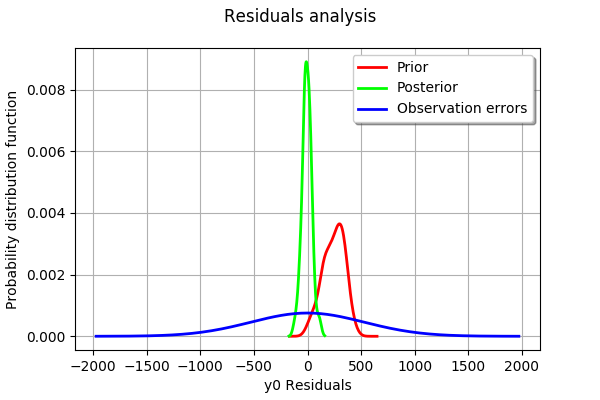

In [26]:
mypcr = CalibrationAnalysis(calibrationResult,model, inputObservations,outputObservations)
mypcr.drawResiduals()

## Create an empirical sample of theta

In [27]:
resampleSize = 500
sampleTheta = ot.Sample(resampleSize,parameterDimension)
sampleTheta.setDescription(descr)
for i in range(resampleSize):
    calibrationResult, inputObservations = generateTheta(size, observationOutputNoise, candidate)
    thetaStar = calibrationResult.getParameterMAP()
    sampleTheta[i] = thetaStar

In [28]:
sampleTheta[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=3 description=[R,C,Gamma] data=[[770.591,3042.85,8.59328],[771.892,2960.13,9.06125],[734.197,2217.84,12.4687],[727.424,1967.34,13.4421],[750.414,2843.42,9.76937]]

## Draw distributions

In [29]:
import pylab as pl
import openturns.viewer as otv

Set the mean of the posterior distribution to the candidate, so that we can compare the variances.

In [30]:
thetaPosterior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[747.009,2735.21,10.1291] sigma=class=Point name=Unnamed dimension=3 values=[187.519,4309.09,18.8889] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.701132,-0.763342,0.701132,1,-0.994947,-0.763342,-0.994947,1]

In [31]:
Sigma = thetaPosterior.getCovariance()
Sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[35163.2,566539,-2703.78,566539,1.85682e+07,-80982.7,-2703.78,-80982.7,356.791]

In [32]:
thetaPosteriorNormal = ot.Normal(candidate,Sigma)
thetaPosteriorNormal

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[700,2500,8] sigma=class=Point name=Unnamed dimension=3 values=[187.519,4309.09,18.8889] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0.701132,-0.763342,0.701132,1,-0.994947,-0.763342,-0.994947,1]

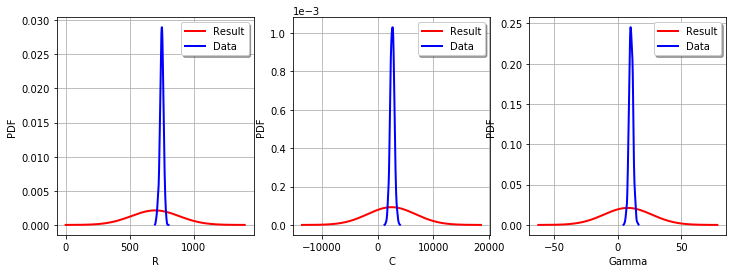

In [33]:
fig = pl.figure(figsize=(12, 4))
for i in range(parameterDimension):
    thetai = thetaPosteriorNormal.getMarginal(i)
    graph = thetai.drawPDF()
    graph.setXTitle(descr[i])
    # From data
    sampleMargin = sampleTheta.getMarginal(i)
    ksdist = ot.KernelSmoothing().build(sampleMargin).drawPDF()
    ksdist.setColors(["blue"])
    graph.add(ksdist)
    graph.setLegends(["Result","Data"])
    ax = fig.add_subplot(1, parameterDimension, i+1)
    _ = otv.View(graph, figure=fig, axes=[ax])